# Initialization

In [9]:
import pandas as pd
import numpy as np
import torch
#import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torchvision import transforms, datasets
import PIL
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Data loading

In [10]:
train_data_path = 'C:/Users/ADMIN/Downloads/cats-and-dogs/train/'
test_data_path =  'C:/Users/ADMIN/Downloads/cats-and-dogs/test/'

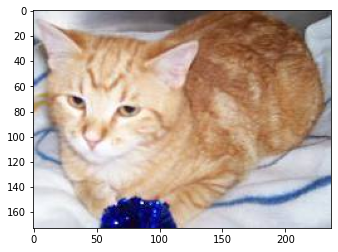

In [11]:
img_x = PIL.Image.open(train_data_path+r'/cats/cat.42.jpg')
plt.imshow(img_x)

In [12]:
device = 'cpu'

# Data preparation

In [13]:
transformers = transforms.Compose(
    [
        transforms.Resize([128,128]),
        transforms.ToTensor()
    ]
)

In [14]:
train_dataset = datasets.ImageFolder(train_data_path, transform=transformers)
test_dataset = datasets.ImageFolder(test_data_path, transform=transformers)

In [15]:
train_data_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_data_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [16]:
for data, target in train_data_loader:
    print(data.shape, target.shape)
    break

torch.Size([64, 3, 128, 128]) torch.Size([64])


In [17]:
torch.cuda.empty_cache()

# Deep learning model

$$W_o = \frac{W_{in} - K + 2P}{S} + 1$$

$$For\ the\ first\ layer $$ 
$$W_1 = \frac{128 - 5 + 2*2}{1} + 1 = 128$$

`Here we are not reducing the size of the image in the convolution layers, but it can be done by changing the kernel_size, stride or setting a padding`

$$W_{in} = Input\ dim\ of\ image \\ W_o = Output\ dim\ of\ image \\ K = Kernel\ size \\ P = Padding \\ S = Stride$$

In [18]:
class catsvsdogs(torch.nn.Module):
    
    def __init__(self):
        
        super(catsvsdogs, self).__init__()

        """
        Convolution layers:

        in_channels = no. of layers in the image when incoming to the convolution layer
        kernel_size = size of convolution filter (k*k) 
        padding = no. of cells to leave at each size of the image
        stride = the step by which the convolution filter moves, deafult = 1
        out_channels = no. of layers in the image when outgoing from the convolution layer, i.e. no. of filters(convolution layers)


        Batch normalization layers:

        num_features = no. of channels in the image


        Pooling layers:

        kernel_size = the size of the matrix to be considered for taking pooling
        stride = step size taken while moving the kernel

        """

        self.bn1 = torch.nn.BatchNorm2d(num_features=3)
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, padding=2)
        # 16 channels * 64 * 64


        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.conv2 = torch.nn.Conv2d(in_channels = 16, out_channels=32, kernel_size=5,padding=2)
        # 32 channels * 32 * 32


        self.bn3 = torch.nn.BatchNorm2d(num_features=32)
        self.conv3 = torch.nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=5,padding=2)
        # 64 channels * 16 * 16


        # self.bn4 = torch.nn.BatchNorm2d(num_features=64)
        # self.conv4 = torch.nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=5,padding=2)
        # 128 channels * 8 * 8

        """
        No learning for pooling and dropout layers
        """

        self.drop = torch.nn.Dropout2d(p=0.2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(in_features=64*16*16, out_features=64) #128 * 8 * 8
        self.fc2 = torch.nn.Linear(in_features=64, out_features=32)
        self.fc3 = torch.nn.Linear(in_features=32, out_features=2)

    def forward(self, x):

        x = self.bn1(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.size())

        x = self.bn2(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.size())

        x = self.bn3(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool(x)
        # print(x.size())

        # x = self.bn4(x)
        # x = self.conv4(x)
        # x = F.relu(x)
        # x = self.pool(x)
        # print(x.size())

        x = self.drop(x)

        """ Convolution layers over, now flattening the image for sending it to DNN"""
        
        x = x.view(x.size()[0], -1)
        # print(x.size())

        x = self.fc1(x)
        x = F.relu(x)
    
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = F.softmax(x, dim=1)
        
        return x

model = catsvsdogs()

# Training and validation methods

In [19]:
def train(
    train_dataloader: DataLoader,  #Changed from train_data_loader
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch_idx: int):

    #model.train()

    training_loss = np.array([])
    training_accuracy = np.array([])

    for train_idx, (data, target) in enumerate(train_dataloader):
        
        data = data.to(device)
        target = target.to(device)
        
        output_prob = model(data)
        loss = F.cross_entropy(output_prob, target)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_loss = np.append(training_loss, loss.item())
        
        pred = output_prob.argmax(axis=1)
        correct = pred.cpu().eq(target.cpu()).sum()
        acc = float(correct)/float(len(target))
        training_accuracy = np.append(training_accuracy, acc)

        if train_idx %100 == 0:
            print(f"Training epoch {epoch_idx} Training loss: {loss.item()} Training accuracy: {acc}")

    return training_loss.mean(), training_accuracy.mean()

In [20]:
def validate(
    test_dataloader : DataLoader,
    model: torch.nn.Module):
    
    #model.eval()

    val_loss = np.array([])
    val_accuracy = np.array([])

    for val_idx, (data_test, target_test) in enumerate(test_dataloader):
        data_test = data_test.to(device)
        target_test = target_test.to(device)

        output_prob_test = model(data_test)

        loss_test = F.cross_entropy(output_prob_test, target_test)
        val_loss = np.append(val_loss, loss_test.item())

        pred_test = output_prob_test.argmax(axis=1)
        correct_test = pred_test.cpu().eq(target_test.cpu()).sum()
        acc_test = float(correct_test)/float(len(target_test))
        val_accuracy = np.append(val_accuracy,acc_test)

        if val_idx%100 == 0:
            print(f"Validation loss: {loss_test.item()} Validation accuracy: {acc_test}")

    return val_loss.mean(), val_accuracy.mean()        


# Model training and evaluation

In [21]:
training_perf = []
validation_perf = []

model = model.to(device)
optimizer = Adam(params = model.parameters(), lr=0.001)

for epoch in range(10):
    train_loss, train_acc = train(train_dataloader=train_data_loader, model = model, optimizer=optimizer, epoch_idx=epoch)
    val_loss, val_acc = validate(test_dataloader=test_data_loader, model = model)

    training_perf.append((train_loss, train_acc))
    validation_perf.append((val_loss, val_acc))

Training epoch 0 Training loss: 0.6984613537788391 Training accuracy: 0.46875
Validation loss: 1.0049484968185425 Validation accuracy: 0.3125
Training epoch 1 Training loss: 0.7262885570526123 Training accuracy: 0.578125
Validation loss: 0.6920867562294006 Validation accuracy: 0.609375
Training epoch 2 Training loss: 0.5139315128326416 Training accuracy: 0.796875
Validation loss: 0.9576815366744995 Validation accuracy: 0.359375
Training epoch 3 Training loss: 0.660285234451294 Training accuracy: 0.65625
Validation loss: 0.7275438904762268 Validation accuracy: 0.578125
Training epoch 4 Training loss: 0.7500357031822205 Training accuracy: 0.546875
Validation loss: 0.8159803748130798 Validation accuracy: 0.46875
Training epoch 5 Training loss: 0.5691211223602295 Training accuracy: 0.71875
Validation loss: 0.5302121639251709 Validation accuracy: 0.78125
Training epoch 6 Training loss: 0.6987911462783813 Training accuracy: 0.59375
Validation loss: 0.4546758532524109 Validation accuracy: 0.8

In [22]:
model

catsvsdogs(
  (bn1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (drop): Dropout2d(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=2, bias=True)
)

# Transfer learning using ResNet model

In [1]:
from torchvision.models import resnet50
base_model = resnet50(pretrained=True, progress=False)

c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
c:\Users\ADMIN\Documents\Codebase\envs\machine_L\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [4]:
for param in base_model.parameters():
    print(param.size())
    param.requires_grad=False           #Freezing the weight parameters of the resnet model so that they are not updated during training

torch.Size([64, 3, 7, 7])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([64, 256, 1, 1])
torch.Size([64])
torch.Size([64])
torch.Size([64, 64, 3, 3])
torch.Size([64])
torch.Size([64])
torch.Size([256, 64, 1, 1])
torch.Size([256])
torch.Size([256])
torch.Size([128, 256, 1, 1])
torch.Size([128])
torch.Size([128])
torch.Size([128, 128, 3, 3])
torch.Size([128])
torch.Size([128])
torch.Size([512, 128, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 256, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([128, 512, 1, 1])
torch.Size([128])
torch.Siz

In [25]:
in_features = base_model.fc.in_features

In [26]:
in_features

2048

In [27]:
list(base_model.children())

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False),
 Sequential(
   (0): Bottleneck(
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (relu): ReLU(inplace=True)
     (downsample): Sequential(
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum

In [28]:
new_model_modules = list(base_model.children())[:-1]        #Taking all the layers except the last fully connected layer, because we are using 3 FC layers with different no. of class outputs
new_model = torch.nn.Sequential(*new_model_modules)
new_model = new_model.to(device)

In [30]:
class resnetcatsanddogs(torch.nn.Module):

    def __init__(self):

        super(resnetcatsanddogs, self).__init__()
        
        self.fc1 = torch.nn.Linear(in_features=in_features, out_features=128*2)     # Here the in_features are the no. of outputs of the 2nd last layers of the resnet50 model
        self.fc2 = torch.nn.Linear(in_features = 128*2, out_features = 64*2)
        self.fc3 = torch.nn.Linear(in_features=64*2, out_features=2)

    def forward(self,x):

        x = new_model(x)            # The resnet50 model upto the 2nd last layer

        x = x.view(x.size()[0],-1)  # Flattening

        x = self.fc1(x)             # CNN -> DNN
        x = F.relu(x)
    
        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)
        x = F.relu(x)
        x = F.softmax(x, dim=1)

        return x


resnet50model = resnetcatsanddogs()

# Train and test functions

In [ ]:
def train(
    train_dataloader: DataLoader,  #Changed from train_data_loader
    model: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    epoch_idx: int):

    #model.train()

    training_loss = np.array([])
    training_accuracy = np.array([])

    for train_idx, (data, target) in enumerate(train_dataloader):
        
        data = data.to(device)
        target = target.to(device)
        
        output_prob = model(data)
        loss = F.cross_entropy(output_prob, target)

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        training_loss = np.append(training_loss, loss.item())
        
        pred = output_prob.argmax(axis=1)
        correct = pred.cpu().eq(target.cpu()).sum()
        acc = float(correct)/float(len(target))
        training_accuracy = np.append(training_accuracy, acc)

        if train_idx %100 == 0:
            print(f"Training epoch {epoch_idx} Training loss: {loss.item()} Training accuracy: {acc}")

    return training_loss.mean(), training_accuracy.mean()





def validate(
    test_dataloader : DataLoader,
    model: torch.nn.Module):
    
    #model.eval()

    val_loss = np.array([])
    val_accuracy = np.array([])

    for val_idx, (data_test, target_test) in enumerate(test_dataloader):
        data_test = data_test.to(device)
        target_test = target_test.to(device)

        output_prob_test = model(data_test)

        loss_test = F.cross_entropy(output_prob_test, target_test)
        val_loss = np.append(val_loss, loss_test.item())

        pred_test = output_prob_test.argmax(axis=1)
        correct_test = pred_test.cpu().eq(target_test.cpu()).sum()
        acc_test = float(correct_test)/float(len(target_test))
        val_accuracy = np.append(val_accuracy,acc_test)

        if val_idx%100 == 0:
            print(f"Validation loss: {loss_test.item()} Validation accuracy: {acc_test}")

    return val_loss.mean(), val_accuracy.mean()        


# ResNet model testing

In [32]:
training_perf = []
validation_perf = []

model = resnet50model.to(device)
optimizer = Adam(params = model.parameters(), lr=0.001)

for epoch in range(10):
    train_loss, train_acc = train(train_dataloader=train_data_loader, model = model, optimizer=optimizer, epoch_idx=epoch)
    val_loss, val_acc = validate(test_dataloader=test_data_loader, model = model)

    training_perf.append((train_loss, train_acc))
    validation_perf.append((val_loss, val_acc))

Training epoch 0 Training loss: 0.6931470632553101 Training accuracy: 0.59375
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 1 Training loss: 0.6931470632553101 Training accuracy: 0.484375
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 2 Training loss: 0.6931470632553101 Training accuracy: 0.53125
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 3 Training loss: 0.6931470632553101 Training accuracy: 0.5
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 4 Training loss: 0.6931470632553101 Training accuracy: 0.546875
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 5 Training loss: 0.6931470632553101 Training accuracy: 0.375
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 6 Training loss: 0.6931470632553101 Training accuracy: 0.609375
Validation loss: 0.6931470632553101 Validation accuracy: 1.0
Training epoch 7 Training loss